이 노트북의 코드에 대한 설명은 [분류기 체인: ClassifierChain](https://tensorflow.blog/2018/02/16/%EB%B6%84%EB%A5%98%EA%B8%B0-%EC%B2%B4%EC%9D%B8-classifierchain/) 글을 참고하세요.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml

fetch yeast dataset (https://www.openml.org/d/40597)

사이킷런 0.20 버전에서 `fetch_openml`이 추가되었습니다. `fetch_mldata`는 0.22 버전에서 삭제될 예정입니다.

In [2]:
yeast = fetch_openml('yeast', version=4)

In [3]:
X = yeast['data']
Y = yeast['target']

In [4]:
X.shape, Y.shape

((2417, 103), (2417, 14))

In [5]:
Y

array([['FALSE', 'FALSE', 'FALSE', ..., 'TRUE', 'TRUE', 'FALSE'],
       ['FALSE', 'FALSE', 'TRUE', ..., 'FALSE', 'FALSE', 'FALSE'],
       ['FALSE', 'TRUE', 'TRUE', ..., 'TRUE', 'TRUE', 'FALSE'],
       ...,
       ['FALSE', 'FALSE', 'FALSE', ..., 'TRUE', 'TRUE', 'FALSE'],
       ['FALSE', 'FALSE', 'FALSE', ..., 'TRUE', 'TRUE', 'FALSE'],
       ['FALSE', 'TRUE', 'TRUE', ..., 'TRUE', 'TRUE', 'FALSE']],
      dtype=object)

In [6]:
Y = Y == 'TRUE'

In [7]:
Y

array([[False, False, False, ...,  True,  True, False],
       [False, False,  True, ..., False, False, False],
       [False,  True,  True, ...,  True,  True, False],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False]])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

for OVR model

In [10]:
ovr = OneVsRestClassifier(LogisticRegression(solver='lbfgs'))
ovr.fit(X_train, Y_train)
pred_ovr = ovr.predict(X_test)

In [11]:
from sklearn.metrics import jaccard_similarity_score
ovr_score = jaccard_similarity_score(Y_test, pred_ovr)
ovr_score

0.5081742752197298

for CC model (https://www.cs.waikato.ac.nz/ml/publications/2009/chains.pdf)

In [12]:
from sklearn.multioutput import ClassifierChain

In [13]:
cc = ClassifierChain(LogisticRegression(solver='lbfgs'), order='random', random_state=42)
cc.fit(X_train, Y_train)
pred_cc = cc.predict(X_test)
cc_score = jaccard_similarity_score(Y_test, pred_cc)
cc_score

0.5111808015217105

for CC ensemble

In [14]:
chains = [ClassifierChain(LogisticRegression(solver='lbfgs'), order='random', random_state=42+i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

In [15]:
pred_chains = np.array([chain.predict(X_test) for chain in chains])
chain_scores = [jaccard_similarity_score(Y_test, pred_chain)
                        for pred_chain in pred_chains]
chain_scores

[0.5111808015217105,
 0.5267951802559241,
 0.5303917271892479,
 0.5147935971283079,
 0.5076409758744469,
 0.49902351436442344,
 0.5088128182652977,
 0.4967048734094188,
 0.5140867053057135,
 0.4871433490751672]

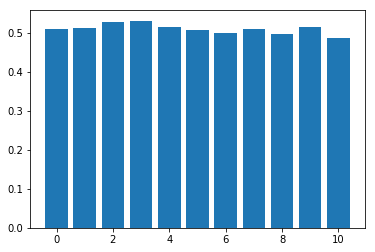

In [16]:
plt.bar(np.arange(11), [ovr_score]+chain_scores)
plt.show()

In [17]:
proba_chains = np.array([chain.predict_proba(X_test) for chain in chains])
proba_ensemble = proba_chains.mean(axis=0)
ensemble_score = jaccard_similarity_score(Y_test, proba_ensemble >= 0.5)
ensemble_score

0.518004722550177

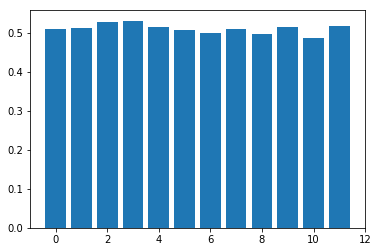

In [18]:
plt.bar(np.arange(12), [ovr_score]+chain_scores+[ensemble_score])
plt.show()